## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib

from copy import deepcopy

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('dark_background')

In [4]:
from pudl_rmi.make_plant_parts_eia import *
pd.options.display.max_columns = None

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing objectDEBUG

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
#pudl_engine = sa.create_engine('sqlite:////Users/christinagosnell/code/pudl_work/sqlite/pudl_wo_ytd.sqlite')

In [7]:
table_compiler = CompileTables(pudl_engine=pudl_engine, freq='AS',)

In [8]:
parts_compiler = CompilePlantParts(table_compiler,clobber=True)

In [9]:
%%time
plant_parts_df = parts_compiler.generate_master_unit_list(qual_records=True, clobber=True)

Generating the master generator table with ownership.
beginning the aggregation for generation_eia923
getting generation_eia923 from the sqlite db
beginning the aggregation for generators_eia860
getting generators_eia860 from the sqlite db
beginning the aggregation for mcoe
getting mcoe from the output object
Allocating net generation from the generation_fuel_eia923 to the generator level instead of using the less complete generation_eia923 table.
No records found with fuel-only records. This is expected.
0.330% of records have are partially off from their 'IDX_PM_FUEL' group
gen v fuel table net gen diff:      42.1%
new v fuel table net gen diff:      99.7%
new v fuel table fuel (mmbtu) diff: 99.6%
13.95% of generator records are more that 5% off from the net generation table
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
getting ownership_eia860 from the sqlite db
getting boiler_generator_assn_eia860 from the sqlite db
gettin

/Users/aesharpe/Desktop/Work/Catalyst_Coop/rmi-ferc1-eia/src/pudl_rmi/make_plant_parts_eia.py:799: UserWarning: ahh merge error! when adding denorm colunms to plant_gen_df we must get the same number of recordsog # of records: 821478 vs  end state #: 901717
  warnings.warn(


true grans found for plant: 126635
true grans found for plant_unit: 130529
true grans found for plant_prime_mover: 40168
true grans found for plant_technology: 70384
true grans found for plant_prime_fuel: 7149
true grans found for plant_ferc_acct: 47896
true grans found for plant_gen: 284603
begin aggregation for: plant
getting plants_eia from the sqlite db
begin aggregation for: plant_unit
begin aggregation for: plant_prime_mover
begin aggregation for: plant_technology
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_ferc_acct
begin aggregation for: plant_gen
getting utilities_eia from the sqlite db


/Users/aesharpe/Desktop/Work/Catalyst_Coop/rmi-ferc1-eia/src/pudl_rmi/make_plant_parts_eia.py:1629: UserWarning: Too many nothings, you nothing. There shouldn't been much
                more than 60 instances of records with zero capacity_mw (and
                therefor zero fraction_owned) and you got 4802.
                
  warnings.warn(


CPU times: user 19min 35s, sys: 3min 16s, total: 22min 51s
Wall time: 26min 54s


In [10]:
parts_compiler.test_run_aggregations()

Begining tests for plant:
  Results for total_fuel_cost: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_unit:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_mover:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_technology:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_fuel:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, Fals

In [11]:
file_path_mul = pathlib.Path().cwd().parent /'outputs' /'master_unit_list.pkl.gz'
file_path_mul_csv = pathlib.Path().cwd().parent / 'outputs'/'master_unit_list.csv.gz'
plant_parts_df.to_csv(file_path_mul_csv)
plant_parts_df.to_pickle(file_path_mul)

In [12]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in parts_compiler.plant_parts.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [13]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'ownership'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='aquamarine', alpha=0.1, label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

<ipython-input-13-1600d134e24a>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))


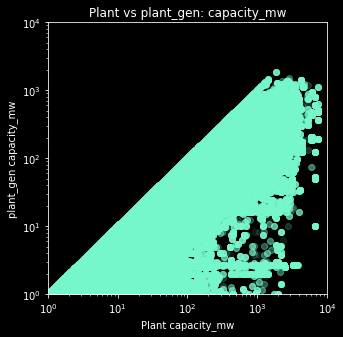

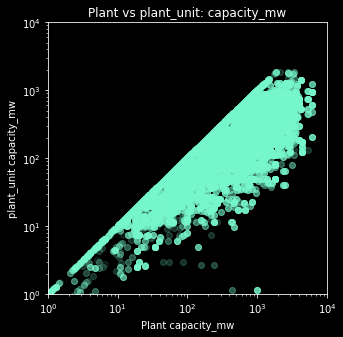

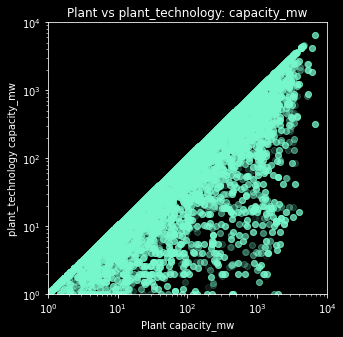

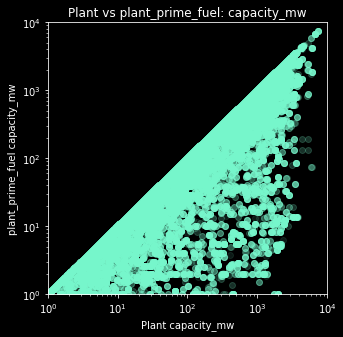

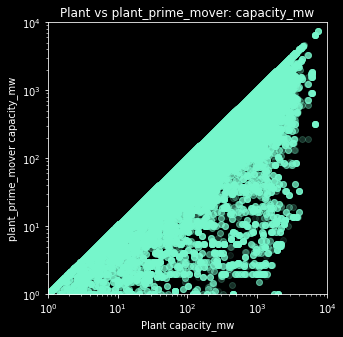

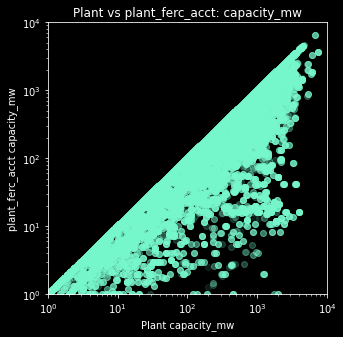

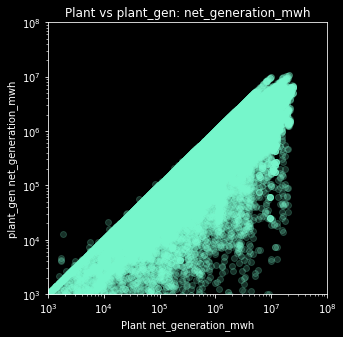

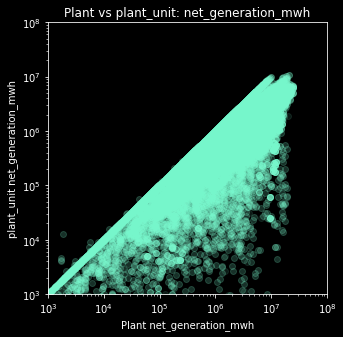

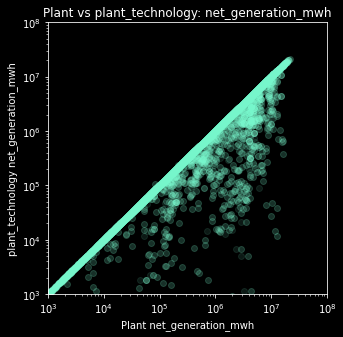

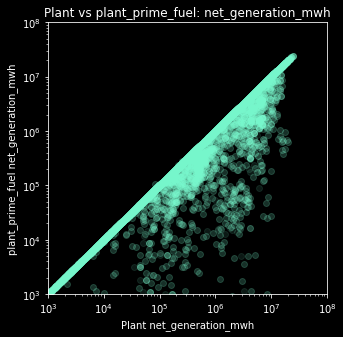

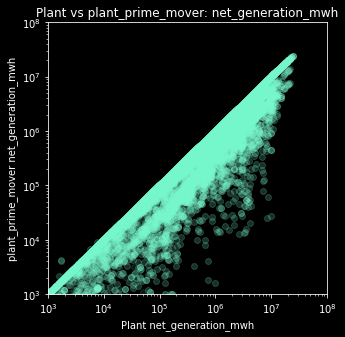

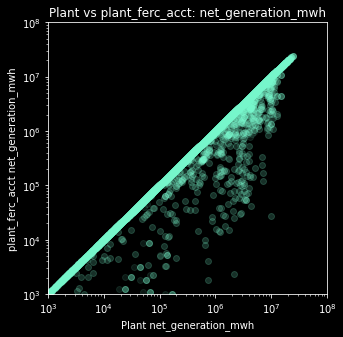

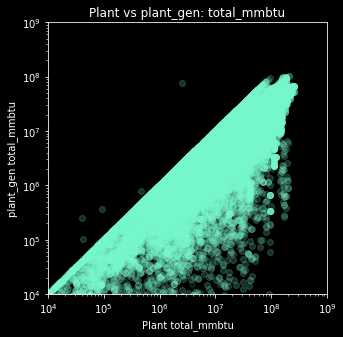

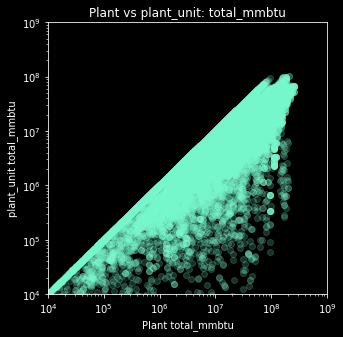

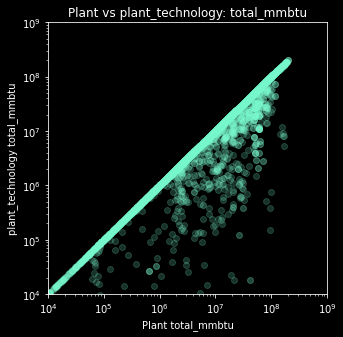

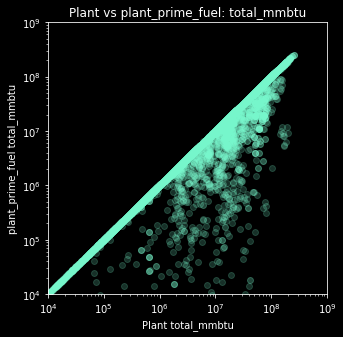

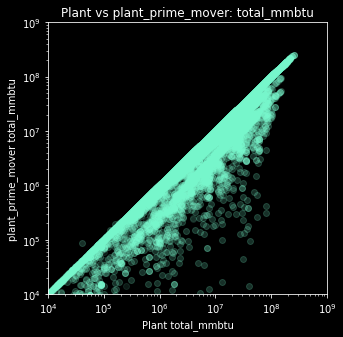

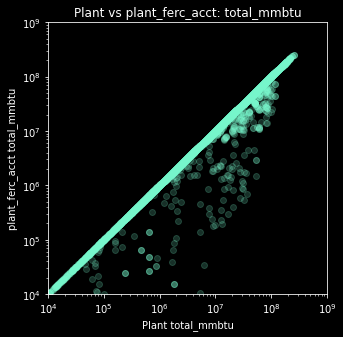

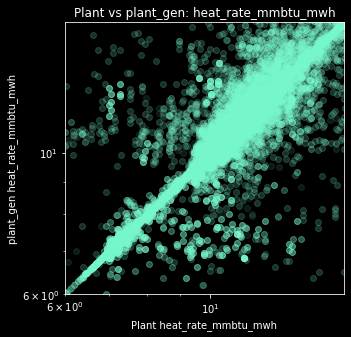

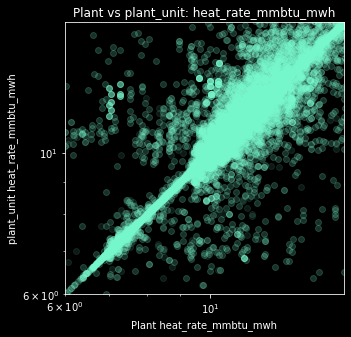

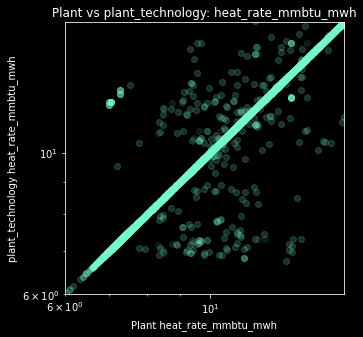

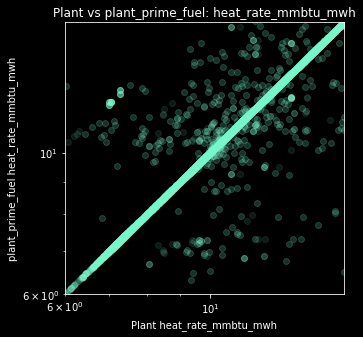

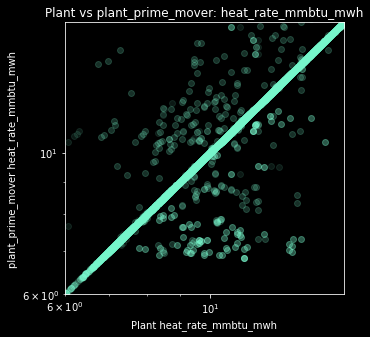

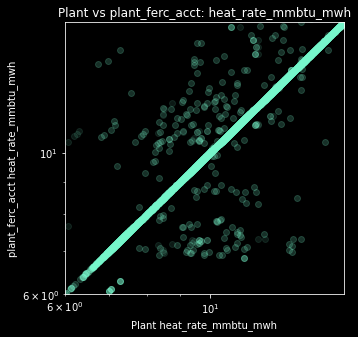

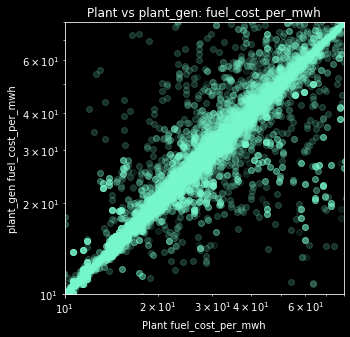

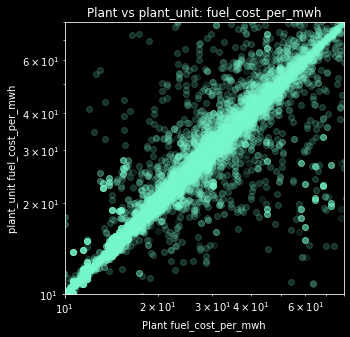

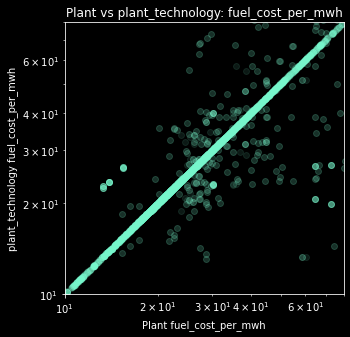

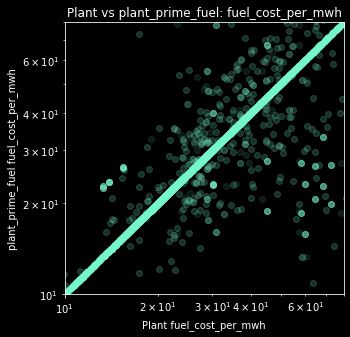

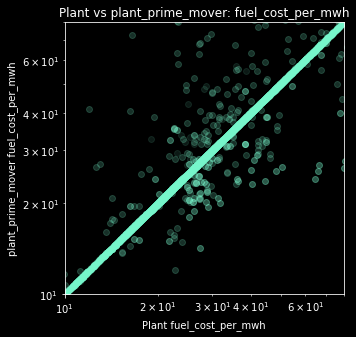

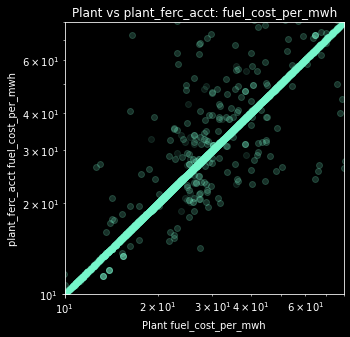

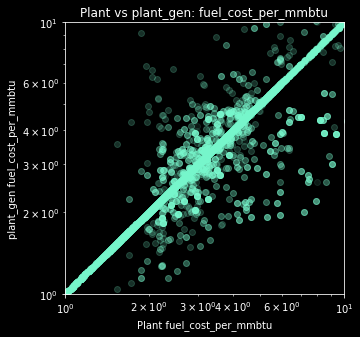

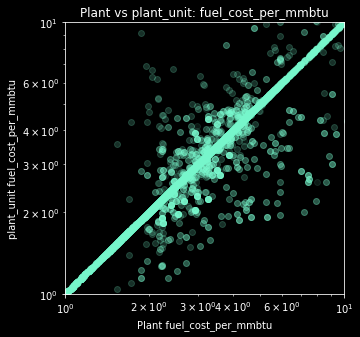

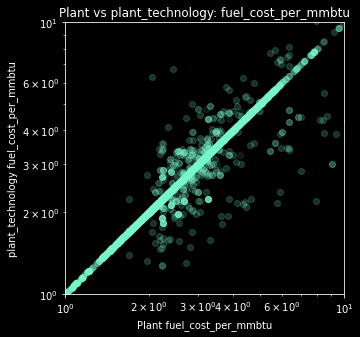

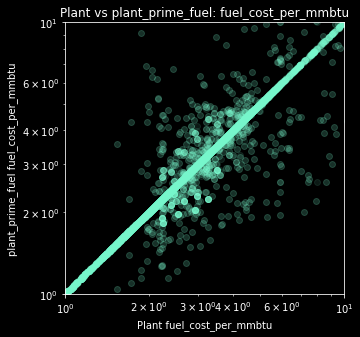

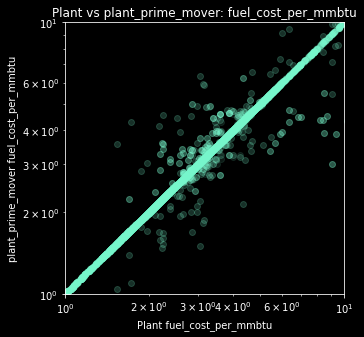

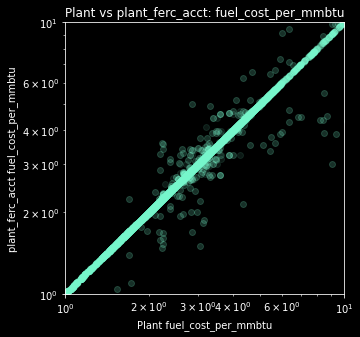

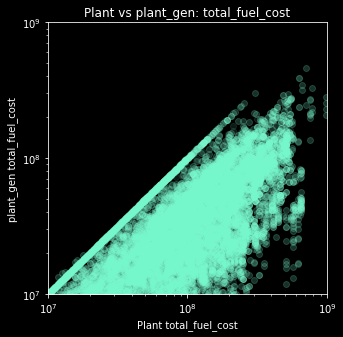

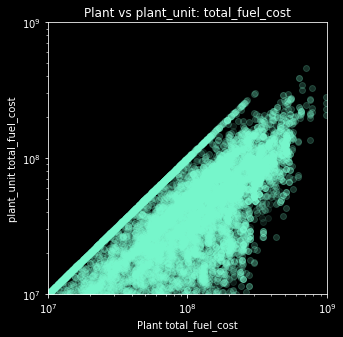

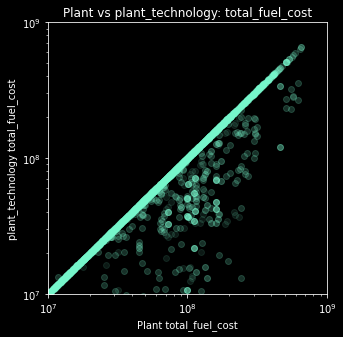

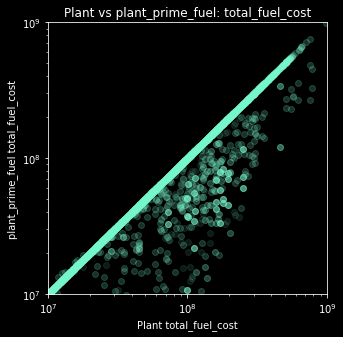

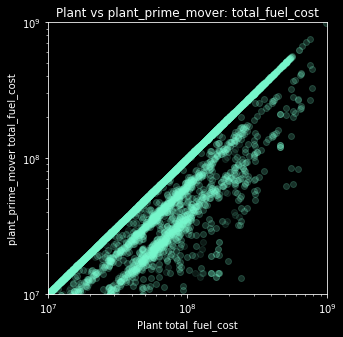

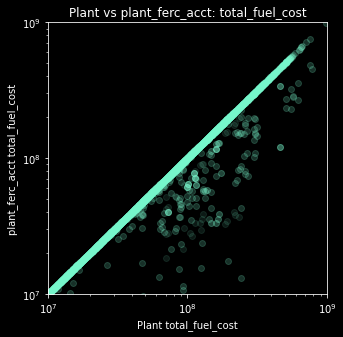

In [14]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [15]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="aquamarine",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [16]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

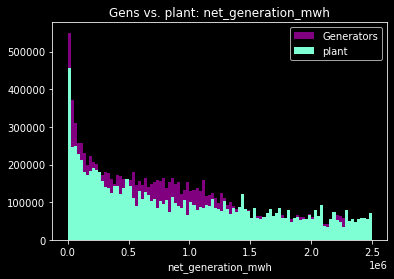

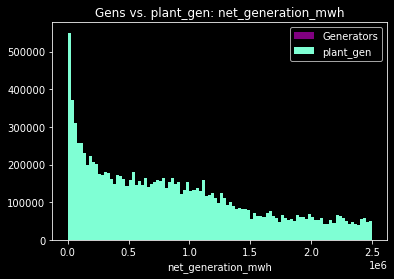

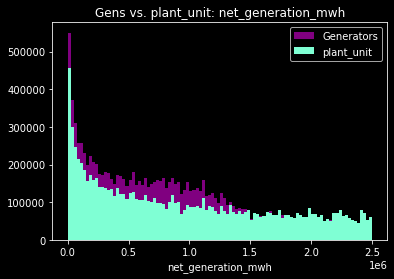

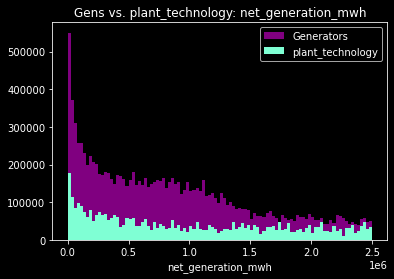

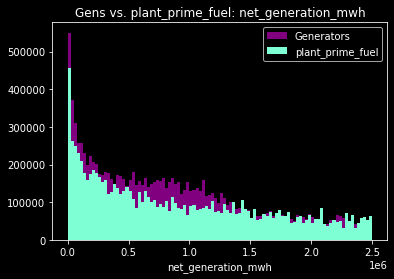

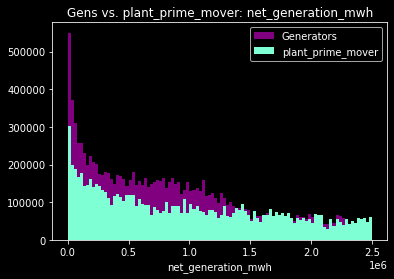

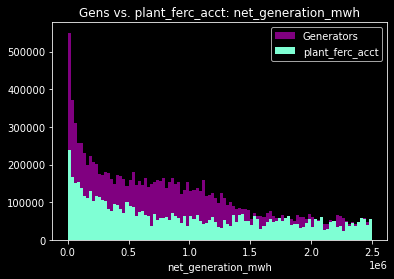

In [17]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

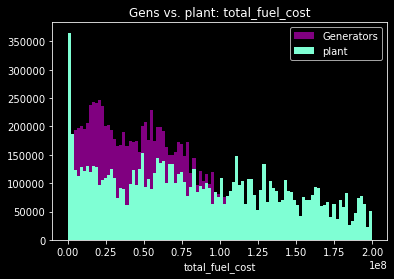

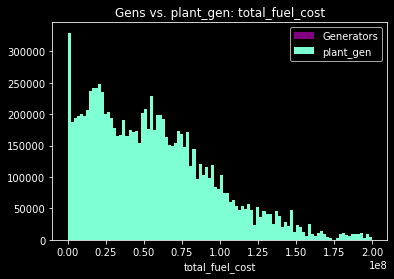

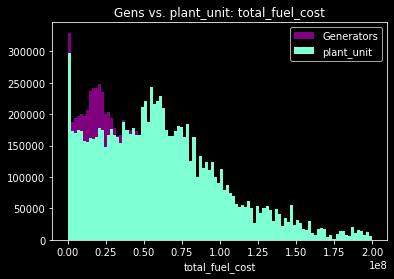

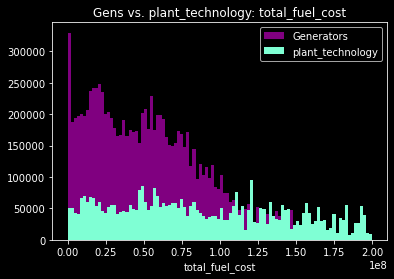

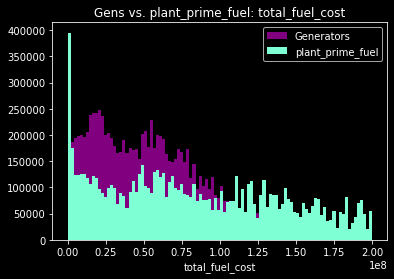

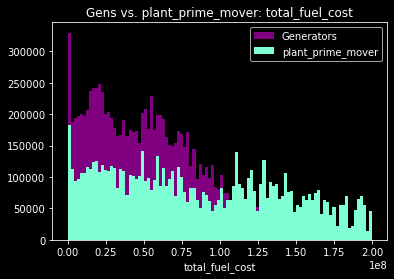

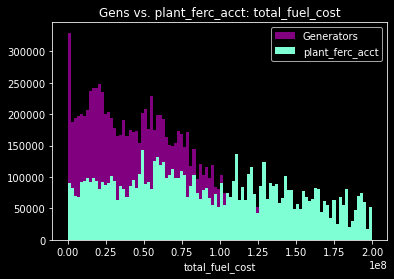

In [18]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

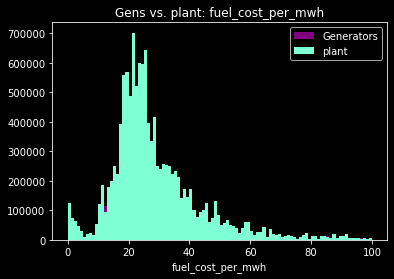

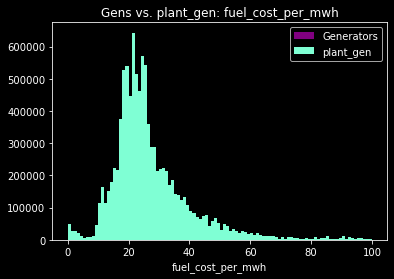

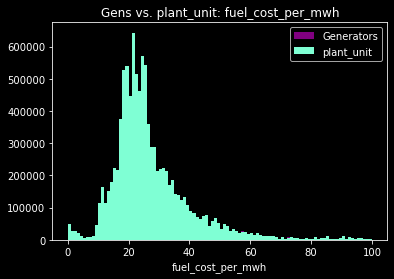

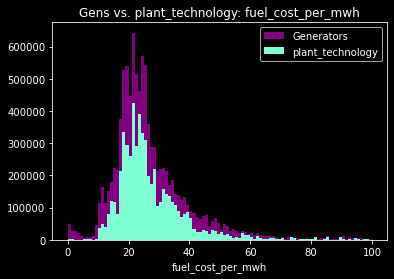

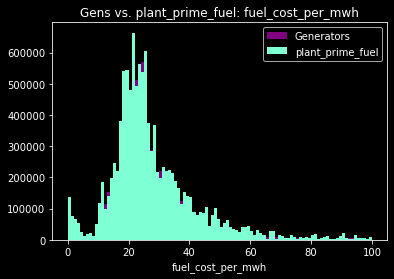

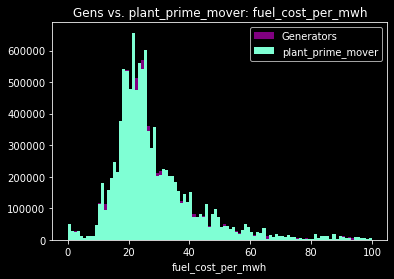

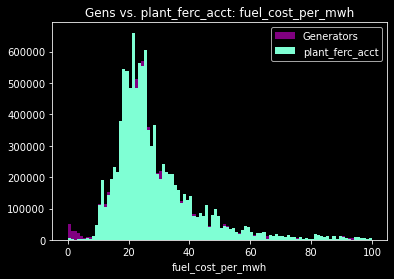

In [19]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

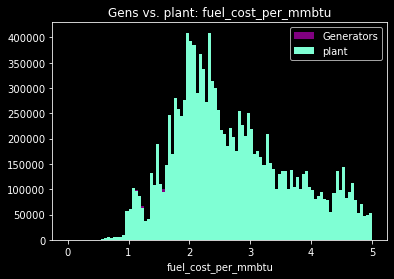

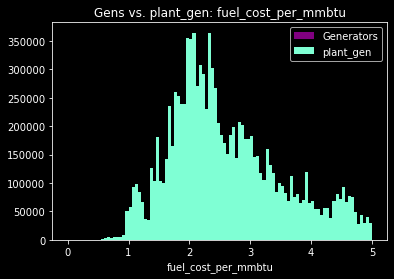

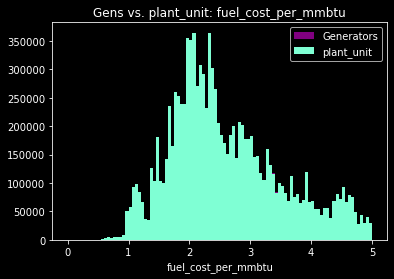

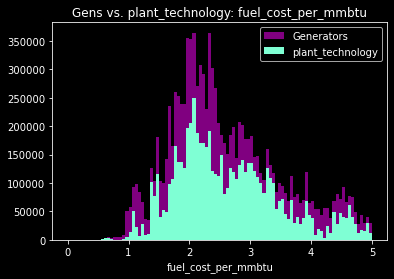

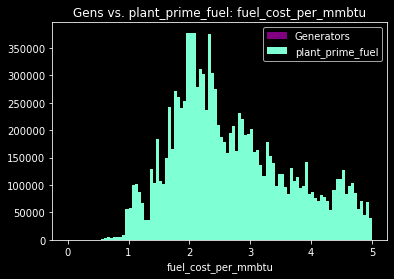

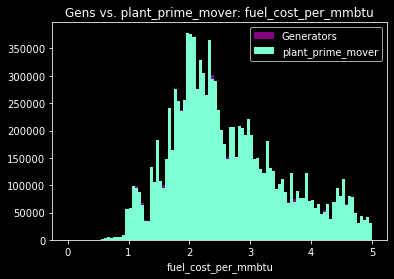

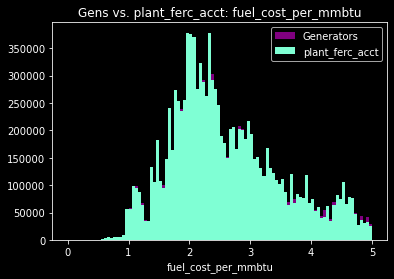

In [20]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [21]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,plant_ferc_acct,total
plant_id_eia,23926,60728,5574,26577,26005,27437,22462,192709
report_date,23926,60728,5574,26577,26005,27437,22462,192709
plant_part,23926,60728,5574,26577,26005,27437,22462,192709
generator_id,12636,60728,3625,14437,14145,15482,12520,133573
unit_id_pudl,1638,9404,5574,2263,2082,3108,1649,25718
prime_mover_code,20894,60532,3999,24852,23927,27437,20759,182400
energy_source_code_1,22008,60728,5514,26365,26005,26573,21621,188814
technology_description,21702,60728,5528,26577,25287,26705,21586,188113
ferc_acct_name,19614,50543,5173,23168,22295,24022,22462,167277
utility_id_eia,23926,60728,5574,26577,26005,27437,22462,192709
